# GIK Character Prediction Model

Train an LSTM model to predict keyboard characters from IMU sensor data.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from pretraining import preprocess_and_export, load_preprocessed_dataset, export_dataset_to_csv
from src.pre_processing.alignment import INDEX_TO_CHAR, CHAR_TO_INDEX
from ml.models.basic_nn import create_model_from_dataset, GIKTrainer, decode_predictions

torch.manual_seed(42)
np.random.seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"PyTorch {torch.__version__} | Device: {DEVICE}")

PyTorch 2.10.0 | Device: mps


## Configuration

In [2]:
# Data paths
DATA_DIR = "data_hazel_1"
KEYBOARD_FILE = "Keyboard_1.csv"
LEFT_FILE = "Left_1.csv"      # Set to None if not available
RIGHT_FILE = None              # Set to None if not available
PROCESSED_DATA_PATH = os.path.join(DATA_DIR, "processed_dataset.pt")

# Training config
CONFIG = {
    'max_seq_length': 10,
    'hidden_dim': 8,
    'num_layers': 1,
    'bidirectional': False,
    'dropout': 0.6,
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 1000,
    'early_stopping': 25,
    # Model: 'lstm' | 'gru' | 'rnn' | 'transformer' | 'cnn'
    'model_type': 'gru',
}

print(f"Data dir: {DATA_DIR}")
print(f"Keyboard: {KEYBOARD_FILE}")
print(f"Left IMU: {LEFT_FILE}")
print(f"Right IMU: {RIGHT_FILE}")
print(f"Model: {CONFIG['model_type']}")

Data dir: data_hazel_1
Keyboard: Keyboard_1.csv
Left IMU: Left_1.csv
Right IMU: None
Model: gru


## Preprocess Data

In [3]:
metadata = preprocess_and_export(
    data_dir=DATA_DIR,
    keyboard_file=KEYBOARD_FILE,
    left_file=LEFT_FILE,
    right_file=RIGHT_FILE,
    output_path=PROCESSED_DATA_PATH,
    max_seq_length=CONFIG['max_seq_length'],
    normalize=True,
    apply_filtering=True
)
print(f"\nSamples: {metadata['num_samples']} | Input dim: {metadata['input_dim']}")

Loading data from data_hazel_1...
Aligning IMU data with keyboard events...


/Users/souparna/perceptron-gik/src/imu/v1/mathlib.py:7: RuntimeWarning: invalid value encountered in divide
  return x / np.linalg.norm(x)
/Users/souparna/perceptron-gik/src/imu/v1/main.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  Ra = [(acc_noise/np.linalg.norm(at))**2 + (1 - grm/np.linalg.norm(at))**2]*3


Skipped characters not in vocabulary: {'shift': 2, '*': 2}
Processing 2111 samples...
Saved preprocessed dataset to data_hazel_1/processed_dataset.pt
Saved metadata to data_hazel_1/processed_dataset_metadata.json
  - Samples: 2111
  - Input dim: 99
  - Hands: 1

Samples: 2111 | Input dim: 99


In [4]:
# Export to CSV for inspection (optional)
export_dataset_to_csv(PROCESSED_DATA_PATH, DATA_DIR, include_features=True)

Saved summary to data_hazel_1/dataset_summary.csv
Saved features to data_hazel_1/dataset_features.csv

Dataset Info:
  Total samples: 2111
  Exported samples: 2111
  Input dim: 99
  Max seq length: 10
  Num classes: 40

Class Distribution:
  SPACE: 384
  e: 225
  o: 157
  t: 132
  n: 116
  a: 116
  l: 110
  r: 95
  i: 88
  s: 82
  h: 81
  w: 57
  d: 53
  m: 51
  g: 46


'data_hazel_1/dataset_summary.csv'

## Load Dataset & Create Model

In [5]:
dataset = load_preprocessed_dataset(PROCESSED_DATA_PATH)
print(f"Dataset: {len(dataset)} samples | Input dim: {dataset.input_dim}")

# Create model (model_type: 'lstm' | 'gru' | 'rnn' | 'transformer' | 'cnn')
model = create_model_from_dataset(
    dataset,
    model_type=CONFIG.get('model_type', 'gru'),
    hidden_dim=CONFIG['hidden_dim'],
    num_layers=CONFIG['num_layers'],
    bidirectional=CONFIG['bidirectional'],
    dropout=CONFIG['dropout'],
)

# Print model architecture
print("\n" + "=" * 60)
print("Model architecture")
print("=" * 60)
print(model)
print("=" * 60)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Dataset: 2111 samples | Input dim: 99

Model architecture
GIKModelWrapper(
  (input_projection): Sequential(
    (0): Linear(in_features=99, out_features=8, bias=True)
    (1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (inner_model): GRUModel(
    (gru): GRU(8, 8, batch_first=True)
    (projection): Identity()
  )
  (classifier): Sequential(
    (0): Linear(in_features=8, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=4, out_features=40, bias=True)
  )
)
Parameters: 1,484
Parameters: 1,484


## Train Model

In [6]:
trainer = GIKTrainer(
    model=model,
    dataset=dataset,
    batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    device=DEVICE
)

history = trainer.train(
    epochs=CONFIG['epochs'],
    early_stopping_patience=CONFIG['early_stopping']
)

Training on mps
Train: 1688, Val: 211, Test: 212 (causal split, no shuffle)
------------------------------------------------------------
Epoch   1/1000 | Train Loss: 3.7724 | Train Acc: 0.0077 | Val Loss: 3.6953 | Val Acc: 0.0047
  -> Saved best model (val_loss: 3.6953)
Epoch   2/1000 | Train Loss: 3.7757 | Train Acc: 0.0083 | Val Loss: 3.6812 | Val Acc: 0.0047
  -> Saved best model (val_loss: 3.6812)
Epoch   3/1000 | Train Loss: 3.7658 | Train Acc: 0.0071 | Val Loss: 3.6668 | Val Acc: 0.0000
  -> Saved best model (val_loss: 3.6668)
Epoch   4/1000 | Train Loss: 3.7519 | Train Acc: 0.0077 | Val Loss: 3.6581 | Val Acc: 0.0000
  -> Saved best model (val_loss: 3.6581)
Epoch   5/1000 | Train Loss: 3.7461 | Train Acc: 0.0041 | Val Loss: 3.6499 | Val Acc: 0.0000
  -> Saved best model (val_loss: 3.6499)
Epoch   6/1000 | Train Loss: 3.7390 | Train Acc: 0.0047 | Val Loss: 3.6429 | Val Acc: 0.0000
  -> Saved best model (val_loss: 3.6429)
Epoch   7/1000 | Train Loss: 3.7297 | Train Acc: 0.0077 | V

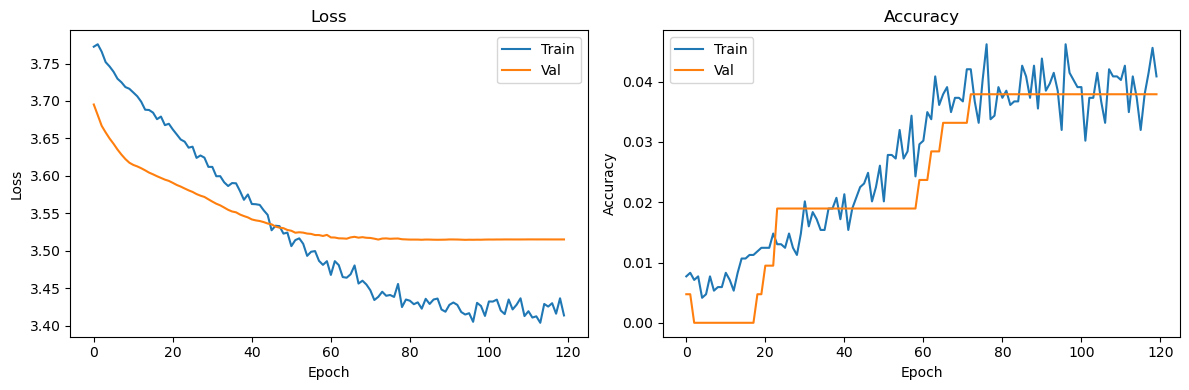

In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

## Evaluate Model

In [8]:
# Evaluate on test set
test_loss, test_acc = trainer.evaluate()
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2%}")

Test Loss: 3.5153 | Test Accuracy: 3.79%


In [9]:
# Sample predictions
model.eval()
with torch.no_grad():
    sample_indices = np.random.choice(len(dataset), min(10, len(dataset)), replace=False)
    for idx in sample_indices:
        x, y_true = dataset[idx]
        x = x.unsqueeze(0).to(DEVICE)
        y_pred = model(x)
        
        true_char = INDEX_TO_CHAR.get(y_true.argmax().item(), '?')
        pred_char = INDEX_TO_CHAR.get(y_pred.argmax().item(), '?')
        
        # Display special chars nicely
        true_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(true_char, true_char)
        pred_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(pred_char, pred_char)
        
        match = '✓' if true_char == pred_char else '✗'
        print(f"{match} True: {true_disp:8} | Pred: {pred_disp:8}")

✗ True: t        | Pred: f       
✗ True: r        | Pred: f       
✗ True: n        | Pred: f       
✗ True: s        | Pred: f       
✗ True: m        | Pred: c       
✗ True: e        | Pred: c       
✗ True: m        | Pred: f       
✗ True: m        | Pred: f       
✗ True: e        | Pred: c       
✗ True: SPACE    | Pred: c       


## Save Model

In [10]:
MODEL_PATH = os.path.join(DATA_DIR, "gik_model.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'input_dim': dataset.input_dim,
    'metadata': metadata
}, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to data_hazel_1/gik_model.pt
